## **Step 1 — Unzip the .tgz dataset in Kaggle and check the folders**

In [1]:
import os
import tarfile

### 1) Find the .tgz file inside /kaggle/input

In [2]:
tgz_path = None
for root, _, files in os.walk("/kaggle/input"):
    for f in files:
        if f.endswith(".tgz"):
            tgz_path = os.path.join(root, f)
            break
    if tgz_path:
        break

print("TGZ file:", tgz_path)

TGZ file: /kaggle/input/lfwpeople/lfw-funneled.tgz


### 2) Extract into /kaggle/working (writeable)

In [3]:
extract_dir = "/kaggle/working/lfwpeople_extracted"
os.makedirs(extract_dir, exist_ok=True)

with tarfile.open(tgz_path, "r:gz") as tar:
    tar.extractall(path=extract_dir)

print("Extracted to:", extract_dir)

Extracted to: /kaggle/working/lfwpeople_extracted


### 3) Show top-level extracted items (to understand structure)

In [4]:
top_items = os.listdir(extract_dir)
print("Top-level items:", top_items[:30])
print("Total top-level items:", len(top_items))

Top-level items: ['lfw_funneled']
Total top-level items: 1


## **Step 2 — Read image paths and labels (names)**

In [5]:
import os

DATA_DIR = "/kaggle/working/lfwpeople_extracted/lfw_funneled"

image_paths = []
labels = []

MIN_IMAGES_PER_PERSON = 10  # important for CNN stability

for person_name in os.listdir(DATA_DIR):
    person_dir = os.path.join(DATA_DIR, person_name)
    if not os.path.isdir(person_dir):
        continue

    images = os.listdir(person_dir)
    if len(images) < MIN_IMAGES_PER_PERSON:
        continue

    for img_name in images:
        if img_name.lower().endswith(".jpg"):
            image_paths.append(os.path.join(person_dir, img_name))
            labels.append(person_name)

print("Total images:", len(image_paths))
print("Total persons:", len(set(labels)))
print("Sample path:", image_paths[0])
print("Sample label:", labels[0])


Total images: 4324
Total persons: 158
Sample path: /kaggle/working/lfwpeople_extracted/lfw_funneled/Mohammed_Al-Douri/Mohammed_Al-Douri_0015.jpg
Sample label: Mohammed_Al-Douri


## **Plotting a sample of images before preprocessing**

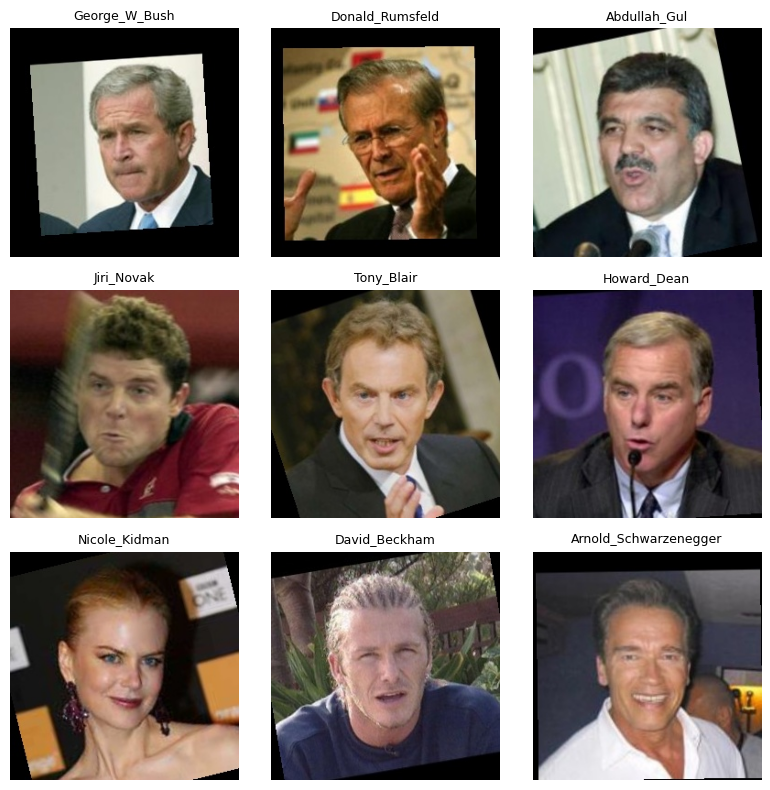

In [6]:
import cv2
import matplotlib.pyplot as plt
import random

# Number of images to show
NUM_SAMPLES = 9

# Randomly choose images
sample_indices = random.sample(range(len(image_paths)), NUM_SAMPLES)

plt.figure(figsize=(8, 8))

for i, idx in enumerate(sample_indices):
    img_path = image_paths[idx]
    label = labels[idx]

    # Read image using OpenCV
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR → RGB for matplotlib

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(label, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


## **Step 3 — Preprocess images with OpenCV (make them easy for the CNN)**

### we will:

### Resize every face image to the same size (example: 128×128)

### Convert to RGB (or grayscale if you want, but RGB is usually better)

### Normalize pixels to 0 → 1 (instead of 0 → 255)

### Convert labels (names) into numbers, because the model learns with numbers

In [7]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [8]:
IMG_SIZE = 128

def preprocess_image(img_path, img_size=IMG_SIZE):
    img = cv2.imread(img_path)  # BGR
    if img is None:
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)     # RGB
    img = cv2.resize(img, (img_size, img_size))    # same size for all
    img = img.astype(np.float32) / 255.0           # normalize to 0..1
    return img

In [9]:
# Convert all images
X_list = []
y_list = []

In [10]:
for p, name in zip(image_paths, labels):
    img = preprocess_image(p)
    if img is None:
        continue
    X_list.append(img)
    y_list.append(name)

X = np.array(X_list, dtype=np.float32)
y_names = np.array(y_list)

In [11]:
print("X shape:", X.shape)          # (N, 128, 128, 3)
print("y_names shape:", y_names.shape)
print("Example label:", y_names[0])

X shape: (4324, 128, 128, 3)
y_names shape: (4324,)
Example label: Mohammed_Al-Douri


In [12]:
# Encode names -> numbers
le = LabelEncoder()
y = le.fit_transform(y_names)

num_classes = len(le.classes_)
print("Number of classes (persons):", num_classes)
print("Encoded example:", y[0], "->", le.inverse_transform([y[0]])[0])

Number of classes (persons): 158
Encoded example: 106 -> Mohammed_Al-Douri


## **Step 4 — Split the data and create PyTorch DataLoaders**

### We will:

### Split images into train (80%) and validation (20%)

### Convert NumPy arrays into PyTorch tensors

### Create DataLoaders so the CNN trains in batches (faster + safer for memory)

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

### **1) Train / Validation split**

In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train samples:", len(X_train))
print("Validation samples:", len(X_val))

Train samples: 3459
Validation samples: 865


### **2) Custom PyTorch Dataset**


In [17]:
class FaceDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx]).permute(2, 0, 1)  # HWC → CHW
        label = torch.tensor(self.labels[idx]).long()
        return img, label

###  **3) Create datasets**


In [18]:
train_dataset = FaceDataset(X_train, y_train)
val_dataset = FaceDataset(X_val, y_val)

### **# 4) DataLoaders (batching)**

In [19]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

### **# 5) Test one batch**

In [20]:
images_batch, labels_batch = next(iter(train_loader))
print("Batch images shape:", images_batch.shape) 
print("Batch labels shape:", labels_batch.shape)

Batch images shape: torch.Size([32, 3, 128, 128])
Batch labels shape: torch.Size([32])


## **Step 5 — Build a simple CNN model (PyTorch)**

### We will build a small CNN with:

#### Conv layers (find patterns)

#### ReLU (helps learning)

#### MaxPool (make it smaller + keep important info)

#### Dropout (reduce overfitting)

#### Fully connected layer (final decision: which person?)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [22]:
class FaceCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Feature extractor
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # 128x128 -> 128x128
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 128x128 -> 128x128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 64x64 -> 64x64

        self.pool = nn.MaxPool2d(2, 2)  # halves width/height
        self.dropout = nn.Dropout(0.3)

        # After 3 pools: 128x128 -> 64x64 -> 32x32 -> 16x16
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # -> 32, 64, 64
        x = self.pool(F.relu(self.conv2(x)))   # -> 64, 32, 32
        x = self.pool(F.relu(self.conv3(x)))   # -> 128, 16, 16

        x = x.view(x.size(0), -1)              # flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)                        # raw scores (logits)
        return x

In [23]:
# Create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FaceCNN(num_classes=num_classes).to(device)

print("Device:", device)
print(model)

Device: cuda
FaceCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=158, bias=True)
)


In [24]:
# Quick test with one batch
images_batch, labels_batch = next(iter(train_loader))
images_batch = images_batch.to(device)

with torch.no_grad():
    out = model(images_batch)

print("Model output shape:", out.shape) 

Model output shape: torch.Size([32, 158])


## **Step 6 — Train the CNN model**

### We will:

#### Use CrossEntropyLoss (best for multi-class classification)

#### Use Adam optimizer (fast and stable)

#### Train for several epochs

#### Check training and validation accuracy

In [25]:
import torch.optim as optim
from tqdm import tqdm

In [26]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10

In [27]:
for epoch in range(EPOCHS):
    # -------- Training --------
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = 100 * train_correct / train_total

    # -------- Validation --------
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Accuracy: {train_acc:.2f}%")
    print(f"Val Accuracy:   {val_acc:.2f}%\n")

Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:00<00:00, 119.80it/s]



Epoch 1/10
Train Accuracy: 11.85%
Val Accuracy:   12.25%



Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:00<00:00, 133.17it/s]



Epoch 2/10
Train Accuracy: 13.39%
Val Accuracy:   16.76%



Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:00<00:00, 130.58it/s]



Epoch 3/10
Train Accuracy: 15.99%
Val Accuracy:   19.42%



Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:00<00:00, 127.96it/s]



Epoch 4/10
Train Accuracy: 23.13%
Val Accuracy:   25.78%



Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:00<00:00, 125.71it/s]



Epoch 5/10
Train Accuracy: 32.35%
Val Accuracy:   33.18%



Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:00<00:00, 136.64it/s]



Epoch 6/10
Train Accuracy: 43.54%
Val Accuracy:   39.88%



Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:00<00:00, 140.31it/s]



Epoch 7/10
Train Accuracy: 53.54%
Val Accuracy:   41.50%



Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:00<00:00, 133.84it/s]



Epoch 8/10
Train Accuracy: 63.69%
Val Accuracy:   42.20%



Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:00<00:00, 125.55it/s]



Epoch 9/10
Train Accuracy: 71.26%
Val Accuracy:   43.47%



Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:00<00:00, 126.48it/s]


Epoch 10/10
Train Accuracy: 77.59%
Val Accuracy:   40.92%



## ***As we see the accuracy is pretty lame and that's because of the dataset is large with so many labels and every label has few images which is not designed to train a model from scratch on***

## **Step 7 — Crop the face (OpenCV) before training**

### we will:

#### detect the face using OpenCV (Haar Cascade)

#### crop the face region (largest face)

#### resize to one fixed size

#### normalize to 0..1

#### This makes the data cleaner, and accuracy usually improves a lot.

In [27]:
IMG_SIZE = 128

# OpenCV built-in Haar Cascade file path
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

In [28]:
def crop_face_opencv(img_rgb):
    """Return cropped face (RGB) or None if no face found."""
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(40, 40)
    )

    if len(faces) == 0:
        return None

    # choose the biggest face
    x, y, w, h = max(faces, key=lambda b: b[2] * b[3])

    # add a small margin around the face
    margin = int(0.2 * max(w, h))
    x1 = max(x - margin, 0)
    y1 = max(y - margin, 0)
    x2 = min(x + w + margin, img_rgb.shape[1])
    y2 = min(y + h + margin, img_rgb.shape[0])

    face = img_rgb[y1:y2, x1:x2]
    return face


In [31]:
X_face_list = []
y_face_list = []
failed = 0

In [32]:
for p, name in tqdm(list(zip(image_paths, labels)), desc="Cropping faces"):
    img_bgr = cv2.imread(p)
    if img_bgr is None:
        failed += 1
        continue

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    face = crop_face_opencv(img_rgb)

    if face is None:
        failed += 1
        continue

    face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
    face = face.astype(np.float32) / 255.0

    X_face_list.append(face)
    y_face_list.append(name)

Cropping faces: 100%|██████████| 4324/4324 [01:09<00:00, 62.49it/s]


In [37]:
X_face = np.array(X_face_list, dtype=np.float32)
y_face_names = np.array(y_face_list)

print("Original images:", len(image_paths))
print("Kept after face crop:", len(X_face_list))
print("Failed (no face / bad read):", failed)
print("X_face shape:", X_face.shape)
print("y_face_names shape:", y_face_names.shape)


Original images: 4324
Kept after face crop: 4309
Failed (no face / bad read): 19
X_face shape: (4309, 128, 128, 3)
y_face_names shape: (4309,)


## Step 8 — Add BatchNorm after every Conv (Modified CNN)

### BatchNorm helps the CNN learn faster and more stable.
### It keeps the values inside the network in a good range, so training becomes easier.

### We will change each block to:
### Conv → BatchNorm → ReLU → MaxPool

### This usually improves validation a lot compared to plain Conv layers.

In [38]:
class FaceCNN_BN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(32)

        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(64)

        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)
        self.bn3   = nn.BatchNorm2d(128)

        # Block 4 (extra depth helps)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False)
        self.bn4   = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)

        # 128x128 -> 64 -> 32 -> 16 -> 8 after 4 pools
        self.fc1 = nn.Linear(256 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FaceCNN_BN(num_classes=num_classes).to(device)

print("Device:", device)
print(model)

Device: cuda
FaceCNN_BN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=158, bias=True)
)


### Use weight decay (helps generalization), and a slightly smaller LR:

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

## Step 9 — Rebuild X, y from the cropped faces + make DataLoaders (with augmentation)

### Now we will train using the cropped faces (X_face) instead of the full photos.

### We will do 4 things:

### Keep only people with enough images (important for good validation)

### Convert names → numbers (label encoding)

### Split into train / validation

### Create PyTorch DataLoaders, with data augmentation only for training

In [41]:
from collections import Counter
from torchvision import transforms

#### 1) Filter people with few images (very important!)

In [43]:
MIN_FACE_IMAGES_PER_PERSON = 20  # trying 20 first, later we can try 30

counts = Counter(y_face_names)
keep_names = {name for name, c in counts.items() if c >= MIN_FACE_IMAGES_PER_PERSON}

mask = np.array([name in keep_names for name in y_face_names], dtype=bool)
Xf = X_face[mask]
yf_names = y_face_names[mask]

print("After filtering:")
print("Images:", len(Xf))
print("Persons:", len(set(yf_names)))

After filtering:
Images: 3009
Persons: 62


#### 2) Encode labels (names -> numbers)

In [44]:
le = LabelEncoder()
yf = le.fit_transform(yf_names)
num_classes = len(le.classes_)
print("num_classes:", num_classes)

num_classes: 62


#### 3) Train/Val split

In [47]:
X_train, X_val, y_train, y_val = train_test_split(
    Xf, yf, test_size=0.2, random_state=42, stratify=yf
)

print("Train:", len(X_train), "Val:", len(X_val))

Train: 2407 Val: 602


#### 4) Dataset + Augmentation

In [48]:
train_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),  # CHW, 0..1
])

val_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

In [49]:
class FaceDatasetAug(Dataset):
    def __init__(self, images, labels, tfm):
        self.images = images
        self.labels = labels
        self.tfm = tfm

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # convert float 0..1 -> uint8 0..255 for PIL transforms
        img = (self.images[idx] * 255).astype(np.uint8)
        img = self.tfm(img)  # tensor CHW float
        label = torch.tensor(self.labels[idx]).long()
        return img, label

In [57]:
BATCH_SIZE = 32

train_loader = DataLoader(
    FaceDatasetAug(X_train, y_train, train_tf),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    FaceDatasetAug(X_val, y_val, val_tf),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

In [58]:
# Quick check
xb, yb = next(iter(train_loader))
print("Batch X:", xb.shape, "Batch y:", yb.shape)

Batch X: torch.Size([32, 3, 128, 128]) Batch y: torch.Size([32])


## Step 10 — Train again (from scratch), but with a better CNN head to reduce overfitting

### Now we train on cropped faces + filtered people + augmentation (from Step 9). ✅
### To make validation better, we’ll use a CNN that:

### has BatchNorm after each Conv

### uses Global Average Pooling (so we don’t need a huge fc layer that overfits)

### We will also:

### use AdamW (good generalization)

### use a learning-rate scheduler (LR goes down slowly while training)

In [52]:
class FaceCNN_GAP_BN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        def block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2)
            )

        self.features = nn.Sequential(
            block(3, 32),    # 128 -> 64
            block(32, 64),   # 64 -> 32
            block(64, 128),  # 32 -> 16
            block(128, 256)  # 16 -> 8
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))   # -> (B, 256, 1, 1)
        self.dropout = nn.Dropout(0.35)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x).squeeze(-1).squeeze(-1)   # -> (B, 256)
        x = self.dropout(x)
        return self.classifier(x) 

In [59]:
model = FaceCNN_GAP_BN(num_classes).to(device)

In [60]:
# Label smoothing helps when classes are many and similar
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

EPOCHS = 20
best_val_acc = 0.0
best_state = None

In [61]:
for epoch in range(EPOCHS):
    # ---- train ----
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = 100.0 * train_correct / train_total
    train_loss /= max(1, len(train_loader))

    # ---- val ----
    model.eval()
    val_correct = 0
    val_total = 0
    val_top5_correct = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            # Top-1
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            # Top-5 (useful when many classes)
            top5 = outputs.topk(5, dim=1).indices
            val_top5_correct += (top5 == labels.view(-1, 1)).any(dim=1).sum().item()

    val_acc = 100.0 * val_correct / val_total
    val_top5_acc = 100.0 * val_top5_correct / val_total

    scheduler.step()

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Acc:    {val_acc:.2f}% | Val Top-5: {val_top5_acc:.2f}%\n")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        print(f"✅ New best Val Acc: {best_val_acc:.2f}% (saved in memory)\n")

Epoch 1/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 58.41it/s]



Epoch 1/20
Train Loss: 3.7868 | Train Acc: 15.66%
Val Acc:    18.27% | Val Top-5: 42.03%

✅ New best Val Acc: 18.27% (saved in memory)



Epoch 2/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 50.33it/s]



Epoch 2/20
Train Loss: 3.6176 | Train Acc: 17.99%
Val Acc:    18.11% | Val Top-5: 44.52%



Epoch 3/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 55.41it/s]



Epoch 3/20
Train Loss: 3.4803 | Train Acc: 19.28%
Val Acc:    19.27% | Val Top-5: 46.35%

✅ New best Val Acc: 19.27% (saved in memory)



Epoch 4/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 53.86it/s]



Epoch 4/20
Train Loss: 3.3729 | Train Acc: 21.94%
Val Acc:    22.43% | Val Top-5: 47.18%

✅ New best Val Acc: 22.43% (saved in memory)



Epoch 5/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 51.63it/s]



Epoch 5/20
Train Loss: 3.2247 | Train Acc: 25.05%
Val Acc:    25.58% | Val Top-5: 53.99%

✅ New best Val Acc: 25.58% (saved in memory)



Epoch 6/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 55.02it/s]



Epoch 6/20
Train Loss: 3.1070 | Train Acc: 26.88%
Val Acc:    26.08% | Val Top-5: 53.16%

✅ New best Val Acc: 26.08% (saved in memory)



Epoch 7/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 53.13it/s]



Epoch 7/20
Train Loss: 3.0166 | Train Acc: 30.20%
Val Acc:    32.89% | Val Top-5: 60.30%

✅ New best Val Acc: 32.89% (saved in memory)



Epoch 8/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 55.76it/s]



Epoch 8/20
Train Loss: 2.9148 | Train Acc: 32.53%
Val Acc:    34.55% | Val Top-5: 63.79%

✅ New best Val Acc: 34.55% (saved in memory)



Epoch 9/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 53.14it/s]



Epoch 9/20
Train Loss: 2.8717 | Train Acc: 34.07%
Val Acc:    38.21% | Val Top-5: 65.61%

✅ New best Val Acc: 38.21% (saved in memory)



Epoch 10/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 54.27it/s]



Epoch 10/20
Train Loss: 2.8381 | Train Acc: 35.90%
Val Acc:    40.37% | Val Top-5: 66.11%

✅ New best Val Acc: 40.37% (saved in memory)



Epoch 11/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 52.54it/s]



Epoch 11/20
Train Loss: 2.8200 | Train Acc: 35.85%
Val Acc:    40.37% | Val Top-5: 66.94%



Epoch 12/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 54.86it/s]



Epoch 12/20
Train Loss: 2.8190 | Train Acc: 36.44%
Val Acc:    40.70% | Val Top-5: 66.61%

✅ New best Val Acc: 40.70% (saved in memory)



Epoch 13/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 57.63it/s]



Epoch 13/20
Train Loss: 2.8280 | Train Acc: 36.56%
Val Acc:    40.70% | Val Top-5: 66.61%



Epoch 14/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 57.21it/s]



Epoch 14/20
Train Loss: 2.8242 | Train Acc: 35.98%
Val Acc:    43.02% | Val Top-5: 68.77%

✅ New best Val Acc: 43.02% (saved in memory)



Epoch 15/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 50.44it/s]



Epoch 15/20
Train Loss: 2.8196 | Train Acc: 37.18%
Val Acc:    40.37% | Val Top-5: 67.11%



Epoch 16/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 52.02it/s]



Epoch 16/20
Train Loss: 2.8013 | Train Acc: 36.48%
Val Acc:    38.37% | Val Top-5: 65.61%



Epoch 17/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 54.15it/s]



Epoch 17/20
Train Loss: 2.7814 | Train Acc: 37.14%
Val Acc:    34.22% | Val Top-5: 62.46%



Epoch 18/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 55.00it/s]



Epoch 18/20
Train Loss: 2.7050 | Train Acc: 39.05%
Val Acc:    39.70% | Val Top-5: 63.62%



Epoch 19/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 50.77it/s]



Epoch 19/20
Train Loss: 2.6606 | Train Acc: 41.50%
Val Acc:    41.03% | Val Top-5: 68.60%



Epoch 20/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 49.76it/s]


Epoch 20/20
Train Loss: 2.6400 | Train Acc: 41.42%
Val Acc:    39.53% | Val Top-5: 69.60%



## Step 11 — Handle class imbalance + use a better loss

### If one person has 80 photos and another has 20, the model learns the 80-photo person better.
### We fix this by:

### giving more weight to rare classes (weighted loss)

### or sampling classes more equally (weighted sampler)

In [56]:
# class weights from training labels
class_counts = np.bincount(y_train, minlength=num_classes).astype(np.float32)
class_weights = class_counts.sum() / (class_counts + 1e-6)   # inverse frequency
class_weights = class_weights / class_weights.mean()         # normalize

class_weights = torch.tensor(class_weights, device=device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

## Step 12 — Stronger augmentation to improve validation

### model still struggles because faces change a lot:

### lighting, small rotations, zoom, blur, and occlusion (glasses, hair, etc.)

### Augmentation teaches the CNN:
### “Even if the face changes a bit, it’s still the same person.”

### We will upgrade the train transform only:

### Random crop + resize (acts like zoom)

### Small rotation

### Color jitter (lighting)

### Random grayscale (sometimes)

### Small blur (camera noise)

### Random erasing (simulates occlusion)

### Validation transform stays simple (no augmentation).

In [62]:
train_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(12),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.15),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.10), ratio=(0.3, 3.3), value="random"),
])


In [63]:
train_loader = DataLoader(
    FaceDatasetAug(X_train, y_train, train_tf),
    batch_size=BATCH_SIZE,
    shuffle=True,          # keep shuffle unless you're using WeightedRandomSampler
    num_workers=2,
    pin_memory=True
)


In [70]:
# --- Loss (keep simple). If you already use weighted loss, keep your old criterion. ---
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# --- Optimizer ---
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# --- Scheduler: reduce LR when val_acc stops improving ---
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",      # because we want to maximize val_acc
    factor=0.5,      # halve LR
    patience=2,      # wait 2 epochs without improvement
    min_lr=1e-6
)

# --- Early stopping settings ---
EPOCHS = 20
PATIENCE = 5

best_val_acc = -1.0
bad_epochs = 0
best_state = None

In [71]:
for epoch in range(EPOCHS):
    # ---------- TRAIN ----------
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # (Optional but helpful) stabilize training
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = 100.0 * train_correct / train_total
    train_loss = train_loss / max(1, len(train_loader))

    # ---------- VAL ----------
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(1)

            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100.0 * val_correct / val_total

    # Scheduler step (based on validation accuracy)
    scheduler.step(val_acc)

    # Print status
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"\nEpoch {epoch+1}/{EPOCHS} | LR: {current_lr:.2e}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Acc:    {val_acc:.2f}%\n")

    # ---------- Early stopping + best checkpoint ----------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        bad_epochs = 0
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        print(f"✅ New best Val Acc: {best_val_acc:.2f}% (saved)\n")
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            print(f"🛑 Early stopping. Best Val Acc: {best_val_acc:.2f}%")
            break

# Restore best model weights at the end
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    print(f"✅ Restored best model (Val Acc: {best_val_acc:.2f}%)")

Epoch 1/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 50.27it/s]



Epoch 1/20 | LR: 3.00e-04
Train Loss: 2.1603 | Train Acc: 57.33%
Val Acc:    63.12%

✅ New best Val Acc: 63.12% (saved)



Epoch 2/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 52.08it/s]



Epoch 2/20 | LR: 3.00e-04
Train Loss: 2.1171 | Train Acc: 58.83%
Val Acc:    65.95%

✅ New best Val Acc: 65.95% (saved)



Epoch 3/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 49.68it/s]



Epoch 3/20 | LR: 3.00e-04
Train Loss: 2.0936 | Train Acc: 60.53%
Val Acc:    60.63%



Epoch 4/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 46.84it/s]



Epoch 4/20 | LR: 3.00e-04
Train Loss: 2.0858 | Train Acc: 59.78%
Val Acc:    68.27%

✅ New best Val Acc: 68.27% (saved)



Epoch 5/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 48.67it/s]



Epoch 5/20 | LR: 3.00e-04
Train Loss: 2.0553 | Train Acc: 61.49%
Val Acc:    67.61%



Epoch 6/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 50.33it/s]



Epoch 6/20 | LR: 3.00e-04
Train Loss: 2.0461 | Train Acc: 61.36%
Val Acc:    67.61%



Epoch 7/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 52.44it/s]



Epoch 7/20 | LR: 1.50e-04
Train Loss: 2.0369 | Train Acc: 62.36%
Val Acc:    67.11%



Epoch 8/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 51.33it/s]



Epoch 8/20 | LR: 1.50e-04
Train Loss: 1.9894 | Train Acc: 63.94%
Val Acc:    67.28%



Epoch 9/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 52.42it/s]



Epoch 9/20 | LR: 1.50e-04
Train Loss: 1.9851 | Train Acc: 64.02%
Val Acc:    71.93%

✅ New best Val Acc: 71.93% (saved)



Epoch 10/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 53.43it/s]



Epoch 10/20 | LR: 1.50e-04
Train Loss: 1.9870 | Train Acc: 63.02%
Val Acc:    69.44%



Epoch 11/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 46.76it/s]



Epoch 11/20 | LR: 1.50e-04
Train Loss: 1.9574 | Train Acc: 64.48%
Val Acc:    72.76%

✅ New best Val Acc: 72.76% (saved)



Epoch 12/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 51.65it/s]



Epoch 12/20 | LR: 1.50e-04
Train Loss: 1.9603 | Train Acc: 64.69%
Val Acc:    72.43%



Epoch 13/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 51.80it/s]



Epoch 13/20 | LR: 1.50e-04
Train Loss: 1.9830 | Train Acc: 64.69%
Val Acc:    63.95%



Epoch 14/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 52.34it/s]



Epoch 14/20 | LR: 7.50e-05
Train Loss: 1.9404 | Train Acc: 65.06%
Val Acc:    69.77%



Epoch 15/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 48.41it/s]



Epoch 15/20 | LR: 7.50e-05
Train Loss: 1.9317 | Train Acc: 65.97%
Val Acc:    73.92%

✅ New best Val Acc: 73.92% (saved)



Epoch 16/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 51.84it/s]



Epoch 16/20 | LR: 7.50e-05
Train Loss: 1.9188 | Train Acc: 66.76%
Val Acc:    69.44%



Epoch 17/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 47.08it/s]



Epoch 17/20 | LR: 7.50e-05
Train Loss: 1.8982 | Train Acc: 67.30%
Val Acc:    68.94%



Epoch 18/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 51.04it/s]



Epoch 18/20 | LR: 7.50e-05
Train Loss: 1.8927 | Train Acc: 67.68%
Val Acc:    74.25%

✅ New best Val Acc: 74.25% (saved)



Epoch 19/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 48.23it/s]



Epoch 19/20 | LR: 7.50e-05
Train Loss: 1.8839 | Train Acc: 67.89%
Val Acc:    72.92%



Epoch 20/20 [Val]: 100%|██████████| 19/19 [00:00<00:00, 50.22it/s]


Epoch 20/20 | LR: 7.50e-05
Train Loss: 1.9173 | Train Acc: 65.97%
Val Acc:    71.26%

✅ Restored best model (Val Acc: 74.25%)


## Step 13 — Save the best model + label encoder mapping

### We must save:

### the model weights

### the list of class names (so predicted index → person name)

### image size and settings

### Without this, you can’t use the model later.

In [82]:
save_path = "/kaggle/working/face_cnn_best.pth"

checkpoint = {
    "model_state_dict": model.state_dict(),
    "class_names": le.classes_,   # important!
    "img_size": IMG_SIZE,
}

torch.save(checkpoint, save_path)
print("Saved to:", save_path)


Saved to: /kaggle/working/face_cnn_best.pth


## Step 14 — Test on a few validation images (show prediction vs truth)

### We will pick random validation images and check:

### true name

### predicted name

### Then we’ll display the image to visually verify.

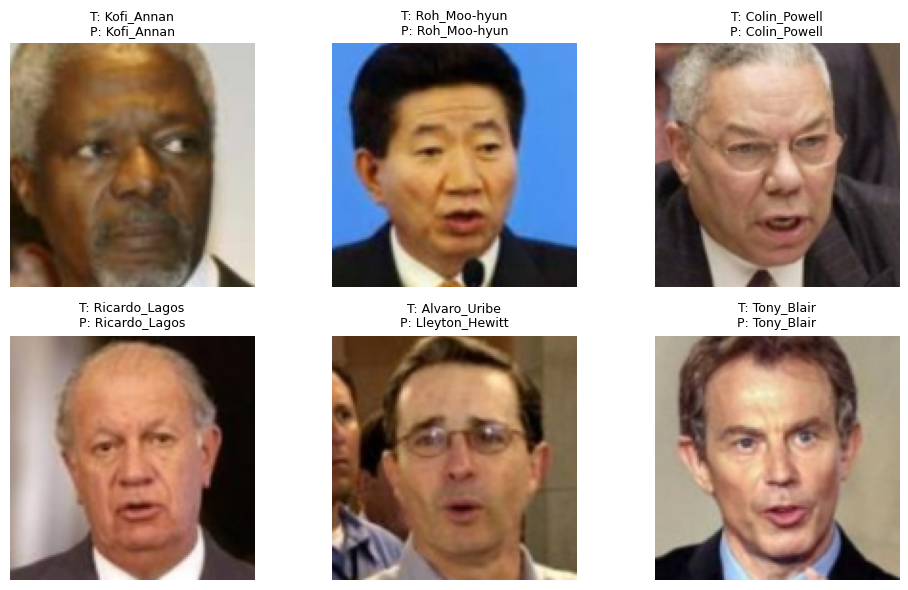

In [81]:
import matplotlib.pyplot as plt

model.eval()

# grab a few samples from val set (X_val, y_val exist from Step 9)
idxs = random.sample(range(len(X_val)), 6)

plt.figure(figsize=(10, 6))

for i, idx in enumerate(idxs):
    img = (X_val[idx] * 255).astype(np.uint8)  # HWC RGB
    x = val_tf(img).unsqueeze(0).to(device)    # (1,3,H,W)

    with torch.no_grad():
        logits = model(x)
        pred = logits.argmax(1).item()

    true_name = le.inverse_transform([y_val[idx]])[0]
    pred_name = le.inverse_transform([pred])[0]

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"T: {true_name}\nP: {pred_name}", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


## Step 15 — add a second dataset + build one combined (paths, labels)

### 1) Set your LFW root 

In [83]:
LFW_ROOT = "/kaggle/working/lfwpeople_extracted/lfw_funneled"

### 2) Find the new dataset folder inside /kaggle/input

In [84]:
print("Datasets in /kaggle/input:", os.listdir("/kaggle/input"))

Datasets in /kaggle/input: ['facescrub-full', 'lfwpeople']


In [86]:
NEW_DATA_BASE = "/kaggle/input/facescrub-full"

def find_folder_with_many_person_dirs(base_dir, min_person_dirs=100):
    # returns a directory that contains many subfolders (people)
    best = None
    best_count = 0
    for root, dirs, files in os.walk(base_dir):
        # a "person folder root" typically has many subfolders
        if len(dirs) > best_count:
            best = root
            best_count = len(dirs)
    return best, best_count

In [87]:
NEW_ROOT, cnt = find_folder_with_many_person_dirs(NEW_DATA_BASE)
print("Auto-found new root:", NEW_ROOT, "| subfolders:", cnt)

Auto-found new root: /kaggle/input/facescrub-full/actress_faces | subfolders: 265


### 3) Build (paths, labels) from any dataset root with structure: root/person_name/*.jpg

In [88]:
def collect_paths_labels(root_dir, prefix, min_imgs_per_person=10):
    paths, labs = [], []
    for person in os.listdir(root_dir):
        person_dir = os.path.join(root_dir, person)
        if not os.path.isdir(person_dir):
            continue
        imgs = [f for f in os.listdir(person_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        if len(imgs) < min_imgs_per_person:
            continue
        for f in imgs:
            paths.append(os.path.join(person_dir, f))
            labs.append(f"{prefix}:{person}")
    return paths, labs

In [89]:
# Tune these
MIN_LFW = 20
MIN_NEW = 20

lfw_paths, lfw_labels = collect_paths_labels(LFW_ROOT, "lfw", MIN_LFW)
new_paths, new_labels = collect_paths_labels(NEW_ROOT, "new", MIN_NEW)

image_paths = lfw_paths + new_paths
labels = lfw_labels + new_labels

print("LFW images:", len(lfw_paths), "classes:", len(set(lfw_labels)))
print("NEW images:", len(new_paths), "classes:", len(set(new_labels)))
print("TOTAL images:", len(image_paths), "TOTAL classes:", len(set(labels)))
print("Example label:", labels[0])

LFW images: 3023 classes: 62
NEW images: 19903 classes: 264
TOTAL images: 22926 TOTAL classes: 326
Example label: lfw:Bill_Clinton


## Step 16 — Crop faces (OpenCV) for the combined dataset and rebuild X_face, y_face_names (same as step 7)

In [90]:
X_face_list = []
y_face_list = []
failed = 0

for p, name in tqdm(list(zip(image_paths, labels)), desc="Cropping faces (combined)"):
    img_bgr = cv2.imread(p)
    if img_bgr is None:
        failed += 1
        continue

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    face = crop_face_opencv(img_rgb)   # from Step 7

    if face is None:
        failed += 1
        continue

    face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
    face = face.astype(np.float32) / 255.0

    X_face_list.append(face)
    y_face_list.append(name)

X_face = np.array(X_face_list, dtype=np.float32)
y_face_names = np.array(y_face_list)

print("Original images:", len(image_paths))
print("Kept after face crop:", len(X_face))
print("Failed (no face / bad read):", failed)
print("X_face shape:", X_face.shape)
print("Unique classes:", len(set(y_face_names)))


Cropping faces (combined): 100%|██████████| 22926/22926 [08:12<00:00, 46.54it/s]


Original images: 22926
Kept after face crop: 21391
Failed (no face / bad read): 1535
X_face shape: (21391, 128, 128, 3)
Unique classes: 326


## Step 17 — Filter classes + encode labels + split + rebuild DataLoaders (for the combined dataset) - (same as step 9 in particular and pervious steps) 

### 1) Filter identities with few images (tune this)

In [102]:
MIN_IMAGES_PER_PERSON = 40

counts = Counter(y_face_names)
keep = {name for name, c in counts.items() if c >= MIN_IMAGES_PER_PERSON}

mask = np.array([name in keep for name in y_face_names], dtype=bool)
Xf = X_face[mask]
yf_names = y_face_names[mask]

print("After filtering -> images:", len(Xf), "| classes:", len(set(yf_names)))

After filtering -> images: 19073 | classes: 245


### 2) Encode labels (names -> numbers)

In [103]:
le = LabelEncoder()
yf = le.fit_transform(yf_names)
num_classes = len(le.classes_)
print("num_classes:", num_classes)

num_classes: 245


### 3) Train/Val split

In [104]:
X_train, X_val, y_train, y_val = train_test_split(
    Xf, yf, test_size=0.2, random_state=42, stratify=yf
)
print("Train:", len(X_train), "Val:", len(X_val))

Train: 15258 Val: 3815


### 4) Transforms (augmentation on train only)

In [105]:
train_tf_mild = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(8),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
])

train_tf_strong = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(12),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.15),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.10), ratio=(0.3, 3.3), value="random"),
])


val_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

### 5) Dataset class

In [95]:
try:
    FaceDatasetAug
except NameError:
    class FaceDatasetAug(Dataset):
        def __init__(self, images, labels, tfm):
            self.images = images
            self.labels = labels
            self.tfm = tfm

        def __len__(self):
            return len(self.images)

        def __getitem__(self, idx):
            img = (self.images[idx] * 255).astype(np.uint8)  # float 0..1 -> uint8
            img = self.tfm(img)
            label = torch.tensor(self.labels[idx]).long()
            return img, label

In [106]:
BATCH_SIZE = 64

train_dataset = FaceDatasetAug(X_train, y_train, train_tf_mild)  # start mild
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    FaceDatasetAug(X_val, y_val, val_tf),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

In [107]:
# Quick check
xb, yb = next(iter(train_loader))
print("Batch X:", xb.shape, "| Batch y:", yb.shape)

Batch X: torch.Size([64, 3, 128, 128]) | Batch y: torch.Size([64])


## Step 14 — Retrain on the combined dataset (the Last“good” training loop that we had on lfw dataset with 74% val_acc)

In [108]:
model = FaceCNN_GAP_BN(num_classes).to(device)

In [110]:
class_counts = np.bincount(y_train, minlength=num_classes).astype(np.float32)
class_weights = class_counts.sum() / (class_counts + 1e-6)
class_weights = class_weights / class_weights.mean()
class_weights = torch.tensor(class_weights, device=device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

In [111]:
optimizer = torch.optim.AdamW(model.parameters(), lr=8e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2, min_lr=1e-6
)

EPOCHS = 20
PATIENCE = 5

best_val_acc = -1.0
bad_epochs = 0
best_state = None

In [112]:
for epoch in range(EPOCHS):
    # ---------- TRAIN ----------
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    WARMUP_EPOCHS = 3

    # ---- auto augmentation switch ----
    train_dataset.tfm = train_tf_mild if epoch < WARMUP_EPOCHS else train_tf_strong
    if epoch == 0:
        print("Augmentation: mild (warmup)")
    elif epoch == WARMUP_EPOCHS:
        print("Augmentation: strong (main training)")

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = 100.0 * train_correct / train_total
    train_loss = train_loss / max(1, len(train_loader))

    # ---------- VAL ----------
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(1)

            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100.0 * val_correct / val_total

    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]["lr"]

    print(f"\nEpoch {epoch+1}/{EPOCHS} | LR: {current_lr:.2e}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Acc:    {val_acc:.2f}%\n")

    # ---------- Early stopping ----------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        bad_epochs = 0
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        print(f"✅ New best Val Acc: {best_val_acc:.2f}% (saved)\n")
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            print(f"🛑 Early stopping. Best Val Acc: {best_val_acc:.2f}%")
            break

Augmentation: mild (warmup)


Epoch 1/20 [Val]: 100%|██████████| 60/60 [00:01<00:00, 36.36it/s]



Epoch 1/20 | LR: 8.00e-04
Train Loss: 5.4461 | Train Acc: 1.34%
Val Acc:    1.91%

✅ New best Val Acc: 1.91% (saved)



Epoch 2/20 [Val]: 100%|██████████| 60/60 [00:01<00:00, 34.79it/s]



Epoch 2/20 | LR: 8.00e-04
Train Loss: 5.1457 | Train Acc: 2.62%
Val Acc:    1.63%



Epoch 3/20 [Val]: 100%|██████████| 60/60 [00:01<00:00, 35.95it/s]



Epoch 3/20 | LR: 8.00e-04
Train Loss: 4.9902 | Train Acc: 4.06%
Val Acc:    3.72%

✅ New best Val Acc: 3.72% (saved)

Augmentation: strong (main training)


Epoch 4/20 [Val]: 100%|██████████| 60/60 [00:01<00:00, 36.01it/s]



Epoch 4/20 | LR: 8.00e-04
Train Loss: 5.0955 | Train Acc: 3.42%
Val Acc:    3.75%

✅ New best Val Acc: 3.75% (saved)



Epoch 5/20 [Val]: 100%|██████████| 60/60 [00:01<00:00, 35.26it/s]



Epoch 5/20 | LR: 8.00e-04
Train Loss: 4.9859 | Train Acc: 4.10%
Val Acc:    5.06%

✅ New best Val Acc: 5.06% (saved)



Epoch 6/20 [Val]: 100%|██████████| 60/60 [00:01<00:00, 34.80it/s]



Epoch 6/20 | LR: 8.00e-04
Train Loss: 4.9014 | Train Acc: 5.58%
Val Acc:    5.50%

✅ New best Val Acc: 5.50% (saved)



Epoch 7/20 [Val]: 100%|██████████| 60/60 [00:01<00:00, 36.23it/s]



Epoch 7/20 | LR: 8.00e-04
Train Loss: 4.8419 | Train Acc: 6.34%
Val Acc:    6.89%

✅ New best Val Acc: 6.89% (saved)



Epoch 8/20 [Val]: 100%|██████████| 60/60 [00:01<00:00, 35.78it/s]



Epoch 8/20 | LR: 8.00e-04
Train Loss: 4.7483 | Train Acc: 7.33%
Val Acc:    8.07%

✅ New best Val Acc: 8.07% (saved)



Epoch 9/20 [Val]: 100%|██████████| 60/60 [00:01<00:00, 35.41it/s]



Epoch 9/20 | LR: 8.00e-04
Train Loss: 4.6750 | Train Acc: 8.70%
Val Acc:    12.06%

✅ New best Val Acc: 12.06% (saved)



Epoch 10/20 [Val]: 100%|██████████| 60/60 [00:01<00:00, 35.95it/s]



Epoch 10/20 | LR: 8.00e-04
Train Loss: 4.5961 | Train Acc: 10.50%
Val Acc:    10.12%



Epoch 11/20 [Val]: 100%|██████████| 60/60 [00:01<00:00, 35.54it/s]



Epoch 11/20 | LR: 8.00e-04
Train Loss: 4.5071 | Train Acc: 12.34%
Val Acc:    6.29%



Epoch 12/20 [Val]: 100%|██████████| 60/60 [00:01<00:00, 35.08it/s]



Epoch 12/20 | LR: 8.00e-04
Train Loss: 4.4166 | Train Acc: 14.27%
Val Acc:    16.64%

✅ New best Val Acc: 16.64% (saved)



Epoch 13/20 [Val]: 100%|██████████| 60/60 [00:01<00:00, 35.03it/s]



Epoch 13/20 | LR: 8.00e-04
Train Loss: 4.3272 | Train Acc: 16.23%
Val Acc:    12.79%



Epoch 14/20 [Val]: 100%|██████████| 60/60 [00:01<00:00, 35.60it/s]



Epoch 14/20 | LR: 8.00e-04
Train Loss: 4.2362 | Train Acc: 17.85%
Val Acc:    17.69%

✅ New best Val Acc: 17.69% (saved)



Epoch 15/20 [Val]: 100%|██████████| 60/60 [00:01<00:00, 35.51it/s]



Epoch 15/20 | LR: 8.00e-04
Train Loss: 4.1343 | Train Acc: 21.03%
Val Acc:    27.05%

✅ New best Val Acc: 27.05% (saved)



Epoch 16/20 [Val]: 100%|██████████| 60/60 [00:01<00:00, 35.15it/s]



Epoch 16/20 | LR: 8.00e-04
Train Loss: 4.0328 | Train Acc: 22.92%
Val Acc:    27.39%

✅ New best Val Acc: 27.39% (saved)



Epoch 17/20 [Val]: 100%|██████████| 60/60 [00:01<00:00, 35.33it/s]



Epoch 17/20 | LR: 8.00e-04
Train Loss: 3.9342 | Train Acc: 25.27%
Val Acc:    31.35%

✅ New best Val Acc: 31.35% (saved)



Epoch 18/20 [Val]: 100%|██████████| 60/60 [00:01<00:00, 36.36it/s]



Epoch 18/20 | LR: 8.00e-04
Train Loss: 3.8240 | Train Acc: 28.60%
Val Acc:    34.18%

✅ New best Val Acc: 34.18% (saved)



Epoch 19/20 [Val]: 100%|██████████| 60/60 [00:01<00:00, 35.09it/s]



Epoch 19/20 | LR: 8.00e-04
Train Loss: 3.7369 | Train Acc: 30.57%
Val Acc:    39.06%

✅ New best Val Acc: 39.06% (saved)



Epoch 20/20 [Val]: 100%|██████████| 60/60 [00:01<00:00, 35.75it/s]


Epoch 20/20 | LR: 8.00e-04
Train Loss: 3.6403 | Train Acc: 33.49%
Val Acc:    36.91%

